In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [3]:
import cnn_new as cnn               # CNN module
import nnet              # ANN module

In [4]:
nn=cnn.conv_net()
ann=nnet.neural_net()

# Inititalize filters and bias

In [5]:
w0,b0=nn.init_kernel_bias(num_inp_channels=3,kernel_size=5,num_kernels=16)
w1,b1=nn.init_kernel_bias(num_inp_channels=16,kernel_size=5,num_kernels=20)
w2,b2=nn.init_kernel_bias(num_inp_channels=20,kernel_size=5,num_kernels=20)
w3,b3=nn.init_kernel_bias(num_inp_channels=20,kernel_size=5,num_kernels=32)

In [6]:
fw0,fb0=ann.init_weights_bias(num_inp=4096,num_out=128)
fw2,fb2=ann.init_weights_bias(num_inp=128,num_out=10)

# Restore Weights

In [7]:
with open('saved_w8s.dump','rb') as f:
	w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2=pickle.load(f)

In [8]:
nn.learning_rate=1e-2
ann.learning_rate=1e-2

# CNN and FC with backprop

In [9]:
def train(X_inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2
    # Feed Forward                        #(batches, 32, 32, 3)
    conv0=nn.conv2d(X_inp,w0,b0)
    aconv0=nn.relu(conv0)
#   pool0,mask0=nn.max_pool(aconv0)  #(batches, 32, 32, 64)

    conv1=nn.conv2d(aconv0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,mask1=nn.max_pool(aconv1)  #(batches, 16, 16, 128)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,mask2=nn.max_pool(aconv2)  #(batches, 8, 8, 128)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,mask3=nn.max_pool(aconv3)  #(batches, 4, 4, 256)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)     #(batches, 4096)

    fc0=ann.feed_forward(flat,fw0,fb0)
    afc0=ann.relu(fc0)
    fc1=ann.feed_forward(afc0,fw1,fb1)
    afc1=ann.relu(fc1)
    fc2=ann.feed_forward(afc1,fw2,fb2)
    afc2=ann.sigmoid(fc2)
    
    #Backprop ANN
    d_afc2=ann.mean_squared_error_der(afc2,y_inp)

    d_fc2=d_afc2*ann.sigmoid_der(afc2)
    d_fc1,d_fw2,d_fb2=ann.backprop(errors=d_fc2,inp=afc1,weights=fw2,biases=fb2)
    fw2+=d_fw2
    fb2+=d_fb2

    d_fc1[fc1<=0]=0
    d_fc0,d_fw1,d_fb1=ann.backprop(errors=d_fc1,inp=afc0,weights=fw1,biases=fb1)
    fw1+=d_fw1
    fb1+=d_fb1
    
    d_fc0[fc0<=0]=0
    err3,d_fw0,d_fb0=ann.backprop(errors=d_fc0,inp=flat,weights=fw0,biases=fb0)
    fw0+=d_fw0
    fb0+=d_fb0
    
    err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)

    # Back prop CNN
    d_conv3=nn.max_pool_back(errors=err3,inp=aconv3,mask=mask3)
#     d_conv3=d_aconv3*nn.relu_der(aconv3,conv3)
    d_conv3[conv3<=0]=0
    d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
    w3+=d_w3
    b3+=d_b3

    d_conv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,mask=mask2)
#     d_conv2=d_aconv2*nn.relu_der(aconv2,conv2)
    d_conv2[conv2<=0]=0
    d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
    w2+=d_w2
    b2+=d_b2

    d_conv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,mask=mask1)
#     d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
    d_conv1[conv1<=0]=0
    d_conv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
    w1+=d_w1
    b1+=d_b1

#     d_conv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,mask=mask0)
#     d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
    d_conv0[conv0<=0]=0
    d_X_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=X_inp,kernels=w0,biases=b0,layer=0)
    w0+=d_w0
    b0+=d_b0

In [10]:
def validate(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
#     pool0,mask0=nn.max_pool(aconv0)

    conv1=nn.conv2d(aconv0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,mask1=nn.max_pool(aconv1)

    conv2=nn.conv2d(pool1,w2,b2)
    aconv2=nn.relu(conv2)
    pool2,mask2=nn.max_pool(aconv2)

    conv3=nn.conv2d(pool2,w3,b3)
    aconv3=nn.relu(conv3)
    pool3,mask3=nn.max_pool(aconv3)  #(batches, 2, 2, 512)

    r,c,d=pool3.shape[1:]
    flat=pool3.reshape(-1,r*c*d)
    
    fc0=ann.feed_forward(flat,fw0,fb0)
    afc0=ann.relu(fc0)
    fc1=ann.feed_forward(afc0,fw1,fb1)
    afc1=ann.relu(fc1)
    fc2=ann.feed_forward(afc1,fw2,fb2)
    afc2=ann.sigmoid(fc2)
    
    ott=afc2
    ans=ott.argmax(axis=1)
    cor=y_inp.argmax(axis=1)
    
    #Backprop ANN
#     d_afc2=ann.mean_squared_error_der(afc2,y_inp)

#     d_fc2=d_afc2*ann.sigmoid_der(afc2)
#     d_fc1,d_fw2,d_fb2=ann.backprop(errors=d_fc2,inp=afc1,weights=fw2,biases=fb2)
#     fw2+=d_fw2
#     fb2+=d_fb2
    
#     d_fc1[fc1<=0]=0
#     d_fc0,d_fw1,d_fb1=ann.backprop(errors=d_fc1,inp=afc0,weights=fw1,biases=fb1)
#     fw1+=d_fw1
#     fb1+=d_fb1

#     d_fc0[fc0<=0]=0
#     err3,d_fw0,d_fb0=ann.backprop(errors=d_fc0,inp=flat,weights=fw0,biases=fb0)
#     fw0+=d_fw0
#     fb0+=d_fb0
    
#     err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)
#   Back prop CNN
#     d_conv3=nn.max_pool_back(errors=err3,inp=aconv3,mask=mask3)
# #     d_conv3=d_aconv3*nn.relu_der(aconv3,conv3)
#     d_conv3[conv3<=0]=0
#     d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
#     w3+=d_w3
#     b3+=d_b3

#     d_conv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,mask=mask2)
# #     d_conv2=d_aconv2*nn.relu_der(aconv2,conv2)
#     d_conv2[conv2<=0]=0
#     d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
#     w2+=d_w2
#     b2+=d_b2

#     d_conv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,mask=mask1)
# #     d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
#     d_conv1[conv1<=0]=0
#     d_conv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
#     w1+=d_w1
#     b1+=d_b1

# #     d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,mask=mask0)
# #     d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
#     d_conv0[conv0<=0]=0
#     d_X_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=X_inp,kernels=w0,biases=b0,layer=0)
#     w0+=d_w0
#     b0+=d_b0
    return ans,cor,ott.squeeze()

In [11]:
# dt.st=0
st=0

In [12]:
sz=4
tot=50000//sz
twprt=vldt=time()
while st<tot:
    perc=st*100/tot
    st+=1
    pvt=time()
    inp,y_inp=dt.batch_gen(size=sz)
    train(inp,y_inp)
    print("\rProgress: {:.2f} %\t Time: {:.4f}".format(perc,time()-pvt),end='')
    if not perc%5:
        print("\nCalculating Validation acc...",end="")
        vdsz=512
#         ck=np.random.randint(0,50000-vdsz)
        ck=6000         # 44.25 %
#         inp,y_inp=dt.batch_gen(size=vdsz,ck=ck)
        pvt=time()
        inp = dt.test_images[ck:ck+vdsz].reshape(-1,32,32,3)
        y_inp = dt.test_labels[ck:ck+vdsz]
        ans,cor,_=validate(inp,y_inp)
        ncor=vdsz-np.count_nonzero(ans-cor)
        acc=ncor*100/vdsz
        print("\rValidation Acc: {:.3f} %\tValidation time: {:.4f} \tTime to validate: {:.4f}".format(acc,time()-pvt,time()-vldt))
        vldt=time()
        if not perc%20:
            with open('saved_w8s.dump','wb') as f:
                pickle.dump((w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2),f)
            print("Saved. {}\t\t\tTime to save: {:.4f}".format(dt.st,time()-twprt))
            twprt=time()

Progress: 0.00 %	 Time: 2.3681
Validation Acc: 12.305 %	Validation time: 5.6101 	Time to validate: 7.9791
Saved. 50			Time to save: 7.9909
Progress: 5.00 %	 Time: 2.0682
Validation Acc: 8.398 %	Validation time: 5.5816 	Time to validate: 118.6698
Progress: 10.00 %	 Time: 2.1096
Validation Acc: 8.398 %	Validation time: 5.5403 	Time to validate: 110.3370
Progress: 10.20 %	 Time: 2.1570

KeyboardInterrupt: 

Prediction:  ship 
Correct answer:  automobile


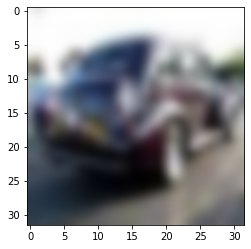

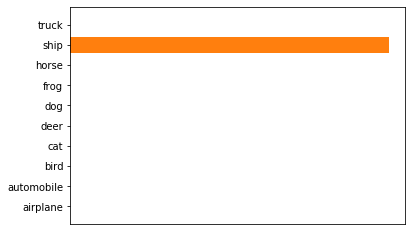

In [65]:
ck=np.random.randint(0,50000)
inp,y_inp=dt.batch_gen(size=1,ck=ck)
ans,cor,ott=validate(inp,y_inp)
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(ott)),ott,color='#ff7f0e')
plt.yticks(range(len(ott)),dt.names)
plt.xticks([])
plt.show()

In [47]:
# Feed Forward                        #(batches, 32, 32, 3)
conv0=nn.conv2d(inp,w0,b0)
aconv0=nn.relu(conv0)
conv1=nn.conv2d(aconv0,w1,b1)
aconv1=nn.relu(conv1)
pool1,mask1=nn.max_pool(aconv1)  #(batches, 16, 16, 128)
conv2=nn.conv2d(pool1,w2,b2)
aconv2=nn.relu(conv2)
pool2,mask2=nn.max_pool(aconv2)  #(batches, 8, 8, 128)
conv3=nn.conv2d(pool2,w3,b3)
aconv3=nn.relu(conv3)
pool3,mask3=nn.max_pool(aconv3)  #(batches, 4, 4, 256)
r,c,d=pool3.shape[1:]
flat=pool3.reshape(-1,r*c*d)     #(batches, 4096)
fc0=ann.feed_forward(flat,fw0,fb0)
afc0=ann.relu(fc0)
fc1=ann.feed_forward(afc0,fw1,fb1)
afc1=ann.relu(fc1)
fc2=ann.feed_forward(afc1,fw2,fb2)
afc2=ann.sigmoid(fc2)
#Backprop ANN
d_afc2=ann.mean_squared_error_der(afc2,y_inp)
d_fc2=d_afc2*ann.sigmoid_der(afc2)
d_fc1,d_fw2,d_fb2=ann.backprop(errors=d_fc2,inp=afc1,weights=fw2,biases=fb2)
fw2+=d_fw2
fb2+=d_fb2
d_fc1[fc1<=0]=0
d_fc0,d_fw1,d_fb1=ann.backprop(errors=d_fc1,inp=afc0,weights=fw1,biases=fb1)
fw1+=d_fw1
fb1+=d_fb1
d_fc0[fc0<=0]=0
err3,d_fw0,d_fb0=ann.backprop(errors=d_fc0,inp=flat,weights=fw0,biases=fb0)
fw0+=d_fw0
fb0+=d_fb0
err3=err3.reshape(-1,r,c,d)            #(batches, 4, 4, 256)
# Back prop CNN
d_conv3=nn.max_pool_back(errors=err3,inp=aconv3,mask=mask3)
d_conv3[conv3<=0]=0
d_pool2,d_w3,d_b3=nn.conv2d_back(errors=d_conv3,inp=pool2,kernels=w3,biases=b3)
w3+=d_w3
b3+=d_b3
d_conv2=nn.max_pool_back(errors=d_pool2,inp=aconv2,mask=mask2)
d_conv2[conv2<=0]=0
d_pool1,d_w2,d_b2=nn.conv2d_back(errors=d_conv2,inp=pool1,kernels=w2,biases=b2)
w2+=d_w2
b2+=d_b2
d_conv1=nn.max_pool_back(errors=d_pool1,inp=aconv1,mask=mask1)
d_conv1[conv1<=0]=0
d_conv0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=aconv0,kernels=w1,biases=b1)
w1+=d_w1
b1+=d_b1
d_conv0[conv0<=0]=0
d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0)
w0+=d_w0
b0+=d_b0

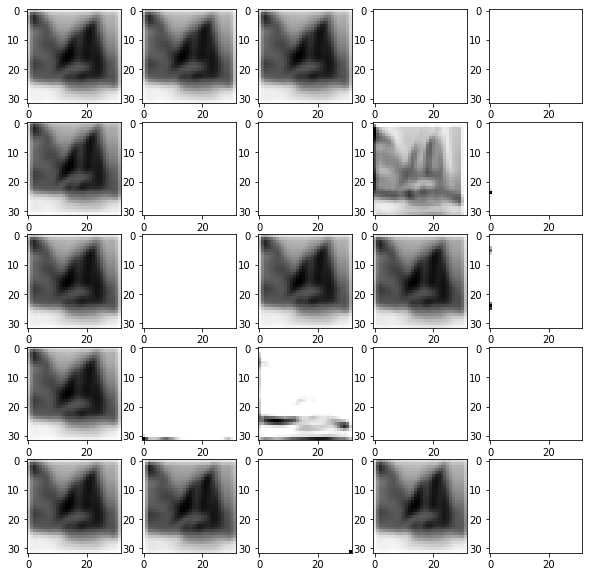

In [45]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=aconv1[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')

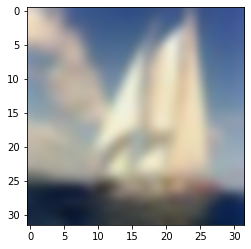

/home/archer/machine_learning/cnn_from_scratch/cnn.py:65: RuntimeWarning: invalid value encountered in true_divide
  x = (x-mn)/(mx-mn)


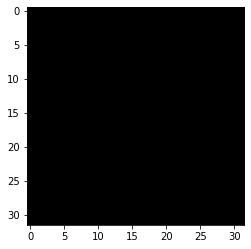

In [48]:
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.imshow(inp[0]+nn.normalize(d_inp)[0],interpolation='bicubic')
plt.show()

# Save/Dump Weights

In [16]:
with open('saved_w8s.dump','wb') as f:
	pickle.dump((w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2),f)

In [95]:
inp,y_inp=dt.batch_gen(size=40,ck=ck)

In [96]:
inp.shape

(40, 32, 32, 3)

In [106]:
%timeit conv0=nn.conv2d(inp,w0,b0)

15.5 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
